### Libraries and functions

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from powershap  import PowerShap
import shapicant
from tqdm import tqdm
from SHAPEffects import FeatureSelector
import random
import shap
import os
import sys
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
os.environ['PYTHONHASHSEED'] = str(1234)
random.seed(1234)
np.random.seed(1234)
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Taken from PowerSHAP paper
def scores_calc_print(Y,Y_pred,print_bool):
    if len(Y_pred) > 1:
        R2_total = r2_score(Y,Y_pred)
    else:
        R2_total = -1
    RMSE_total = mean_squared_error(Y,Y_pred, squared=False)
    MAE_total = mean_absolute_error(Y,Y_pred)
    
    if print_bool:
        print(tabulate([[RMSE_total, MAE_total,R2_total]], ["RMSE","MAE","R²"], tablefmt="grid"))
    else:
        return {"R2":R2_total,"RMSE":RMSE_total,"MAE":MAE_total}

### Data

In [3]:
current_db = pd.read_csv(r"Data/slice_localization_data.csv")
# current_db = current_db.reset_index()

Index_col = "patientId"
target_col = "reference"

Train-test split

In [4]:
train_idx,test_idx = train_test_split(current_db[Index_col].unique(),test_size=0.25,random_state = 1)
current_db_train = current_db[current_db[Index_col].isin(train_idx)]
train_idx, val_idx = train_test_split(current_db_train[Index_col].unique(),test_size=0.37,random_state = 1)
current_db_val = current_db_train[current_db_train[Index_col].isin(val_idx)]
current_db_train = current_db[current_db[Index_col].isin(train_idx)]
current_db_test = current_db[current_db[Index_col].isin(test_idx)]

In [5]:
current_db_val_test = current_db_val.append(current_db_test)

In [6]:
len(current_db_train), len(current_db_val), len(current_db_test), len(current_db), len(current_db_train) + len(current_db_val) + len(current_db_test)

(29372, 11975, 12153, 53500, 53500)

In [8]:
X_train = current_db_train[list(current_db_train.columns.values[2:-1])]
y_train = current_db_train[target_col]

X_val = current_db_val[list(current_db_val.columns.values[2:-1])]
y_val = current_db_val[target_col]

X_test = current_db_test[list(current_db_test.columns.values[2:-1])]
y_test = current_db_test[target_col]

In [10]:
X_train_val = X_train.append(X_val)
y_train_val = y_train.append(y_val)

In [11]:
current_db_train_val = current_db_train.append(current_db_val)

In [12]:
seeds = np.random.randint(1, 999999, 50)

In [13]:
scaler = MinMaxScaler()
scaler_obj = MinMaxScaler()
scaler.fit(X_train)
scaler_obj.fit(y_train.to_numpy().reshape(-1, 1))

X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

y_train_norm = scaler_obj.transform(y_train.to_numpy().reshape(-1, 1)).reshape(len(y_train))
y_val_norm = scaler_obj.transform(y_val.to_numpy().reshape(-1, 1)).reshape(len(y_val))
y_test_norm = scaler_obj.transform(y_test.to_numpy().reshape(-1, 1)).reshape(len(y_test))

## Lasso 0.01

In [14]:
model = Lasso(alpha = 0.01)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.01)

In [15]:
features_lasso_001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_001

['value114',
 'value135',
 'value222',
 'value225',
 'value241',
 'value272',
 'value273',
 'value280',
 'value281',
 'value3',
 'value314',
 'value370',
 'value378',
 'value4',
 'value48',
 'value78',
 'value89']

In [16]:
dict_results_lasso_001 = {'rmse':[], 'mae':[], 'r2':[]}

In [17]:
X_test_lasso_001 = X_test[features_lasso_001]
X_train_lasso_001= X_train[features_lasso_001]
X_val_lasso_001 = X_val[features_lasso_001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_001, y_train,
        eval_set=(X_val_lasso_001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_001), print_bool=False)
    
    dict_results_lasso_001["r2"].append(test_results["R2"])
    dict_results_lasso_001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [18]:
results_lasso_001_df = pd.DataFrame(dict_results_lasso_001)
mean_lasso_001_test = results_lasso_001_df.mean()
std_lasso_001_test = results_lasso_001_df.std()
max_lasso_001_test = results_lasso_001_df.max()
min_lasso_001_test = results_lasso_001_df.min()

In [19]:
mean_lasso_001_test, std_lasso_001_test, max_lasso_001_test, min_lasso_001_test

(rmse    11.307152
 mae      6.813716
 r2       0.716072
 dtype: float64,
 rmse    0.117583
 mae     0.125006
 r2      0.005919
 dtype: float64,
 rmse    11.673765
 mae      7.087381
 r2       0.728348
 dtype: float64,
 rmse    11.060613
 mae      6.586466
 r2       0.697394
 dtype: float64)

## Lasso 0.001

In [20]:
model = Lasso(alpha = 0.001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.001)

In [21]:
features_lasso_0001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_0001

['value106',
 'value110',
 'value113',
 'value114',
 'value115',
 'value116',
 'value118',
 'value120',
 'value125',
 'value126',
 'value130',
 'value132',
 'value134',
 'value135',
 'value136',
 'value137',
 'value140',
 'value145',
 'value146',
 'value150',
 'value153',
 'value163',
 'value170',
 'value174',
 'value180',
 'value182',
 'value186',
 'value190',
 'value191',
 'value192',
 'value200',
 'value210',
 'value212',
 'value213',
 'value215',
 'value220',
 'value222',
 'value224',
 'value225',
 'value226',
 'value227',
 'value230',
 'value236',
 'value237',
 'value241',
 'value242',
 'value25',
 'value250',
 'value251',
 'value252',
 'value265',
 'value266',
 'value268',
 'value272',
 'value273',
 'value274',
 'value277',
 'value280',
 'value281',
 'value291',
 'value297',
 'value299',
 'value3',
 'value300',
 'value307',
 'value312',
 'value314',
 'value319',
 'value322',
 'value323',
 'value329',
 'value330',
 'value331',
 'value336',
 'value338',
 'value339',
 'value35',
 'v

In [22]:
dict_results_lasso_0001 = {'rmse':[], 'mae':[], 'r2':[]}

In [23]:
X_test_lasso_0001 = X_test[features_lasso_0001]
X_train_lasso_0001= X_train[features_lasso_0001]
X_val_lasso_0001 = X_val[features_lasso_0001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_0001, y_train,
        eval_set=(X_val_lasso_0001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_0001), print_bool=False)
    
    dict_results_lasso_0001["r2"].append(test_results["R2"])
    dict_results_lasso_0001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_0001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [24]:
results_lasso_0001_df = pd.DataFrame(dict_results_lasso_0001)
mean_lasso_0001_test = results_lasso_0001_df.mean()
std_lasso_0001_test = results_lasso_0001_df.std()
max_lasso_0001_test = results_lasso_0001_df.max()
min_lasso_0001_test = results_lasso_0001_df.min()

In [25]:
mean_lasso_0001_test, std_lasso_0001_test, max_lasso_0001_test, min_lasso_0001_test

(rmse    7.014769
 mae     4.323011
 r2      0.890686
 dtype: float64,
 rmse    0.149314
 mae     0.084552
 r2      0.004622
 dtype: float64,
 rmse    7.312140
 mae     4.470591
 r2      0.904984
 dtype: float64,
 rmse    6.541387
 mae     4.125335
 r2      0.881274
 dtype: float64)

## Lasso 0.0001

In [26]:
model = Lasso(alpha = 0.0001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=0.0001)

In [27]:
features_lasso_00001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_00001

['value1',
 'value10',
 'value100',
 'value101',
 'value102',
 'value103',
 'value105',
 'value106',
 'value107',
 'value110',
 'value111',
 'value113',
 'value114',
 'value115',
 'value116',
 'value118',
 'value119',
 'value120',
 'value121',
 'value122',
 'value123',
 'value125',
 'value126',
 'value127',
 'value13',
 'value130',
 'value132',
 'value133',
 'value134',
 'value135',
 'value136',
 'value137',
 'value139',
 'value14',
 'value140',
 'value141',
 'value142',
 'value143',
 'value144',
 'value145',
 'value146',
 'value15',
 'value150',
 'value151',
 'value152',
 'value153',
 'value154',
 'value155',
 'value156',
 'value157',
 'value16',
 'value160',
 'value161',
 'value162',
 'value163',
 'value164',
 'value166',
 'value17',
 'value170',
 'value171',
 'value172',
 'value173',
 'value174',
 'value175',
 'value176',
 'value177',
 'value178',
 'value18',
 'value180',
 'value182',
 'value183',
 'value186',
 'value187',
 'value188',
 'value19',
 'value190',
 'value191',
 'value19

In [28]:
dict_results_lasso_00001 = {'rmse':[], 'mae':[], 'r2':[]}

In [29]:
X_test_lasso_00001 = X_test[features_lasso_00001]
X_train_lasso_00001= X_train[features_lasso_00001]
X_val_lasso_00001 = X_val[features_lasso_00001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_00001, y_train,
        eval_set=(X_val_lasso_00001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_00001), print_bool=False)
    
    dict_results_lasso_00001["r2"].append(test_results["R2"])
    dict_results_lasso_00001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_00001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [30]:
results_lasso_00001_df = pd.DataFrame(dict_results_lasso_00001)
mean_lasso_00001_test = results_lasso_00001_df.mean()
std_lasso_00001_test = results_lasso_00001_df.std()
max_lasso_00001_test = results_lasso_00001_df.max()
min_lasso_00001_test = results_lasso_00001_df.min()

In [31]:
mean_lasso_00001_test, std_lasso_00001_test, max_lasso_00001_test, min_lasso_00001_test

(rmse    7.102244
 mae     4.397759
 r2      0.887935
 dtype: float64,
 rmse    0.163322
 mae     0.096686
 r2      0.005137
 dtype: float64,
 rmse    7.440628
 mae     4.641669
 r2      0.899327
 dtype: float64,
 rmse    6.733316
 mae     4.208981
 r2      0.877065
 dtype: float64)

## Lasso 0.00001

In [32]:
model = Lasso(alpha = 0.00001)
model.fit(X_train_norm, y_train_norm)

Lasso(alpha=1e-05)

In [33]:
features_lasso_000001 = sorted(list(X_train.columns[np.abs(model.coef_) > sys.float_info.epsilon]))
features_lasso_000001

['value1',
 'value10',
 'value100',
 'value101',
 'value102',
 'value103',
 'value104',
 'value105',
 'value106',
 'value107',
 'value108',
 'value109',
 'value11',
 'value110',
 'value111',
 'value112',
 'value113',
 'value114',
 'value115',
 'value116',
 'value117',
 'value118',
 'value119',
 'value120',
 'value121',
 'value122',
 'value123',
 'value124',
 'value125',
 'value126',
 'value127',
 'value129',
 'value13',
 'value130',
 'value131',
 'value132',
 'value133',
 'value134',
 'value135',
 'value136',
 'value137',
 'value138',
 'value139',
 'value14',
 'value140',
 'value141',
 'value142',
 'value143',
 'value144',
 'value145',
 'value146',
 'value147',
 'value149',
 'value15',
 'value150',
 'value151',
 'value152',
 'value153',
 'value154',
 'value155',
 'value156',
 'value157',
 'value16',
 'value160',
 'value161',
 'value162',
 'value163',
 'value164',
 'value165',
 'value166',
 'value167',
 'value17',
 'value170',
 'value171',
 'value172',
 'value173',
 'value174',
 'value1

In [34]:
dict_results_lasso_000001 = {'rmse':[], 'mae':[], 'r2':[]}

In [35]:
X_test_lasso_000001 = X_test[features_lasso_000001]
X_train_lasso_000001= X_train[features_lasso_000001]
X_val_lasso_000001 = X_val[features_lasso_000001]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_lasso_000001, y_train,
        eval_set=(X_val_lasso_000001, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_lasso_000001), print_bool=False)
    
    dict_results_lasso_000001["r2"].append(test_results["R2"])
    dict_results_lasso_000001["rmse"].append(test_results["RMSE"])
    dict_results_lasso_000001["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [36]:
results_lasso_000001_df = pd.DataFrame(dict_results_lasso_000001)
mean_lasso_000001_test = results_lasso_000001_df.mean()
std_lasso_000001_test = results_lasso_000001_df.std()
max_lasso_000001_test = results_lasso_000001_df.max()
min_lasso_000001_test = results_lasso_000001_df.min()

In [37]:
mean_lasso_000001_test, std_lasso_000001_test, max_lasso_000001_test, min_lasso_000001_test

(rmse    7.134556
 mae     4.363900
 r2      0.886901
 dtype: float64,
 rmse    0.179122
 mae     0.090692
 r2      0.005702
 dtype: float64,
 rmse    7.502714
 mae     4.577743
 r2      0.899454
 dtype: float64,
 rmse    6.729083
 mae     4.206471
 r2      0.875005
 dtype: float64)

## Boruta

In [38]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='gini',
                              classification=False)

Feature_Selector.fit(X=X_train_val, y=y_train_val, sample=False,
                        train_or_test = 'test', normalize=True,verbose=True)

# 1 minutos 46 segundos

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [12:41<00:00, 38.05s/it]

182 attributes confirmed important: ['value160', 'value122', 'value113', 'value120', 'value265', 'value300', 'value23', 'value47', 'value308', 'value273', 'value61', 'value200', 'value84', 'value126', 'value6', 'value373', 'value202', 'value162', 'value276', 'value2', 'value258', 'value145', 'value339', 'value123', 'value192', 'value246', 'value228', 'value116', 'value44', 'value125', 'value320', 'value329', 'value362', 'value52', 'value18', 'value136', 'value213', 'value237', 'value108', 'value4', 'value130', 'value182', 'value230', 'value382', 'value219', 'value184', 'value190', 'value124', 'value191', 'value231', 'value102', 'value117', 'value377', 'value100', 'value331', 'value222', 'value26', 'value5', 'value266', 'value142', 'value10', 'value233', 'value64', 'value105', 'value249', 'value17', 'value203', 'value112', 'value121', 'value106', 'value171', 'value111', 'value256', 'value314', 'value96', 'value232', 'value223', 'value54', 'value210', 'value25', 'value298', 'value242', '

In [39]:
subset = Feature_Selector.Subset()
selected_features_boruta = sorted(subset.columns.values)
selected_features_boruta

['value1',
 'value10',
 'value100',
 'value101',
 'value102',
 'value104',
 'value105',
 'value106',
 'value108',
 'value110',
 'value111',
 'value112',
 'value113',
 'value114',
 'value115',
 'value116',
 'value117',
 'value118',
 'value12',
 'value120',
 'value121',
 'value122',
 'value123',
 'value124',
 'value125',
 'value126',
 'value127',
 'value128',
 'value13',
 'value130',
 'value131',
 'value132',
 'value133',
 'value134',
 'value135',
 'value136',
 'value138',
 'value14',
 'value140',
 'value141',
 'value142',
 'value143',
 'value145',
 'value146',
 'value150',
 'value151',
 'value158',
 'value16',
 'value160',
 'value161',
 'value162',
 'value17',
 'value170',
 'value171',
 'value172',
 'value173',
 'value174',
 'value18',
 'value180',
 'value181',
 'value182',
 'value183',
 'value184',
 'value190',
 'value191',
 'value192',
 'value2',
 'value200',
 'value201',
 'value202',
 'value203',
 'value207',
 'value21',
 'value210',
 'value211',
 'value212',
 'value213',
 'value214'

In [40]:
dict_results_boruta = {'rmse':[], 'mae':[], 'r2':[]}

In [41]:
X_test_boruta = X_test[selected_features_boruta]
X_train_boruta = X_train[selected_features_boruta]
X_val_boruta = X_val[selected_features_boruta]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_boruta, y_train,
        eval_set=(X_val_boruta, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_boruta), print_bool=False)
    
    dict_results_boruta["r2"].append(test_results["R2"])
    dict_results_boruta["rmse"].append(test_results["RMSE"])
    dict_results_boruta["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [42]:
results_boruta_df = pd.DataFrame(dict_results_boruta)
mean_boruta_test = results_boruta_df.mean()
std_boruta_test = results_boruta_df.std()
max_boruta_test = results_boruta_df.max()
min_boruta_test = results_boruta_df.min()

In [43]:
mean_boruta_test, std_boruta_test, max_boruta_test, min_boruta_test

(rmse    7.192086
 mae     4.409453
 r2      0.885066
 dtype: float64,
 rmse    0.185222
 mae     0.108955
 r2      0.005894
 dtype: float64,
 rmse    7.554016
 mae     4.670831
 r2      0.902571
 dtype: float64,
 rmse    6.623942
 mae     4.122980
 r2      0.873290
 dtype: float64)

## PIMP

In [44]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
model = model.fit(
    X_train, y_train,
    verbose = 0,
    plot=False
)

In [45]:
pimp = PermutationImportance(model, cv='prefit').fit(X_val, y_val)

In [46]:
pimp.feature_importances_

array([ 3.62829962e-05,  6.78945455e-05,  5.89116633e-03,  1.62190980e-02,
       -9.56784776e-05,  1.08728059e-04,  7.74227986e-06,  1.10373300e-03,
       -6.76121277e-06,  1.01695928e-03,  4.23806868e-05,  7.33232452e-05,
       -1.38079205e-04,  1.42816835e-04,  9.71902627e-04, -1.30116096e-03,
        2.48405815e-05,  4.45468886e-03, -2.52272854e-05,  0.00000000e+00,
       -1.37023779e-04,  5.45813221e-05, -4.69828835e-04, -4.77582316e-05,
       -6.53676348e-04,  6.91126193e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.51351232e-04,  0.00000000e+00,  3.17268283e-04,
        4.96926147e-04,  0.00000000e+00,  7.40849318e-05,  7.81490080e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.13003667e-05,
        0.00000000e+00,  2.45281054e-04, -4.74445141e-05,  1.89398540e-04,
        7.47989366e-04,  0.00000000e+00,  7.69441386e-04,  0.00000000e+00,
        0.00000000e+00,  1.30509345e-04, -5.94284475e-05,  1.27319636e-04,
        2.26706411e-04,  

In [47]:
sel = SelectFromModel(pimp,threshold=None, prefit=True)

In [48]:
sel.transform(X_train).shape

(29372, 33)

In [49]:
selected_features_pimp = sorted(list(X_train.columns[sel.get_support()]))
selected_features_pimp

['value108',
 'value110',
 'value114',
 'value115',
 'value116',
 'value118',
 'value122',
 'value135',
 'value136',
 'value145',
 'value170',
 'value172',
 'value175',
 'value18',
 'value210',
 'value215',
 'value226',
 'value227',
 'value228',
 'value230',
 'value232',
 'value237',
 'value242',
 'value273',
 'value299',
 'value3',
 'value300',
 'value314',
 'value341',
 'value370',
 'value378',
 'value382',
 'value4']

In [50]:
dict_results_pimp = {'rmse':[], 'mae':[], 'r2':[]}

In [51]:
X_test_pimp = X_test[selected_features_pimp]
X_train_pimp = X_train[selected_features_pimp]
X_val_pimp = X_val[selected_features_pimp]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_pimp, y_train,
        eval_set=(X_val_pimp, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_pimp), print_bool=False)
    
    dict_results_pimp["r2"].append(test_results["R2"])
    dict_results_pimp["rmse"].append(test_results["RMSE"])
    dict_results_pimp["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [52]:
results_pimp_df = pd.DataFrame(dict_results_pimp)
mean_pimp_test = results_pimp_df.mean()
std_pimp_test = results_pimp_df.std()
max_pimp_test = results_pimp_df.max()
min_pimp_test = results_pimp_df.min()

In [53]:
mean_pimp_test, std_pimp_test, max_pimp_test, min_pimp_test

(rmse    7.941774
 mae     4.818047
 r2      0.859892
 dtype: float64,
 rmse    0.160419
 mae     0.075246
 r2      0.005672
 dtype: float64,
 rmse    8.334552
 mae     4.973614
 r2      0.871301
 dtype: float64,
 rmse    7.613086
 mae     4.640289
 r2      0.845752
 dtype: float64)

# Results

In [54]:
nombres = ['Lasso_0.01', 'Lasso_0.001', 'Lasso_0.0001', 'Lasso_0.00001', 'Boruta', 'PIMP']

## MAE

In [55]:
resultados_mae_mean = [mean_lasso_001_test['mae'], mean_lasso_0001_test['mae'], mean_lasso_00001_test['mae'], mean_lasso_000001_test['mae'], mean_boruta_test['mae'], mean_pimp_test['mae']]
resultados_mae_std = [std_lasso_001_test['mae'], std_lasso_0001_test['mae'], std_lasso_00001_test['mae'], std_lasso_000001_test['mae'], std_boruta_test['mae'], std_pimp_test['mae']]
resultados_mae_max = [max_lasso_001_test['mae'], max_lasso_0001_test['mae'], max_lasso_00001_test['mae'], max_lasso_000001_test['mae'], max_boruta_test['mae'], max_pimp_test['mae']]
resultados_mae_min = [min_lasso_001_test['mae'], min_lasso_0001_test['mae'], min_lasso_00001_test['mae'], min_lasso_000001_test['mae'], min_boruta_test['mae'], min_pimp_test['mae']]

(4.0, 7.5)

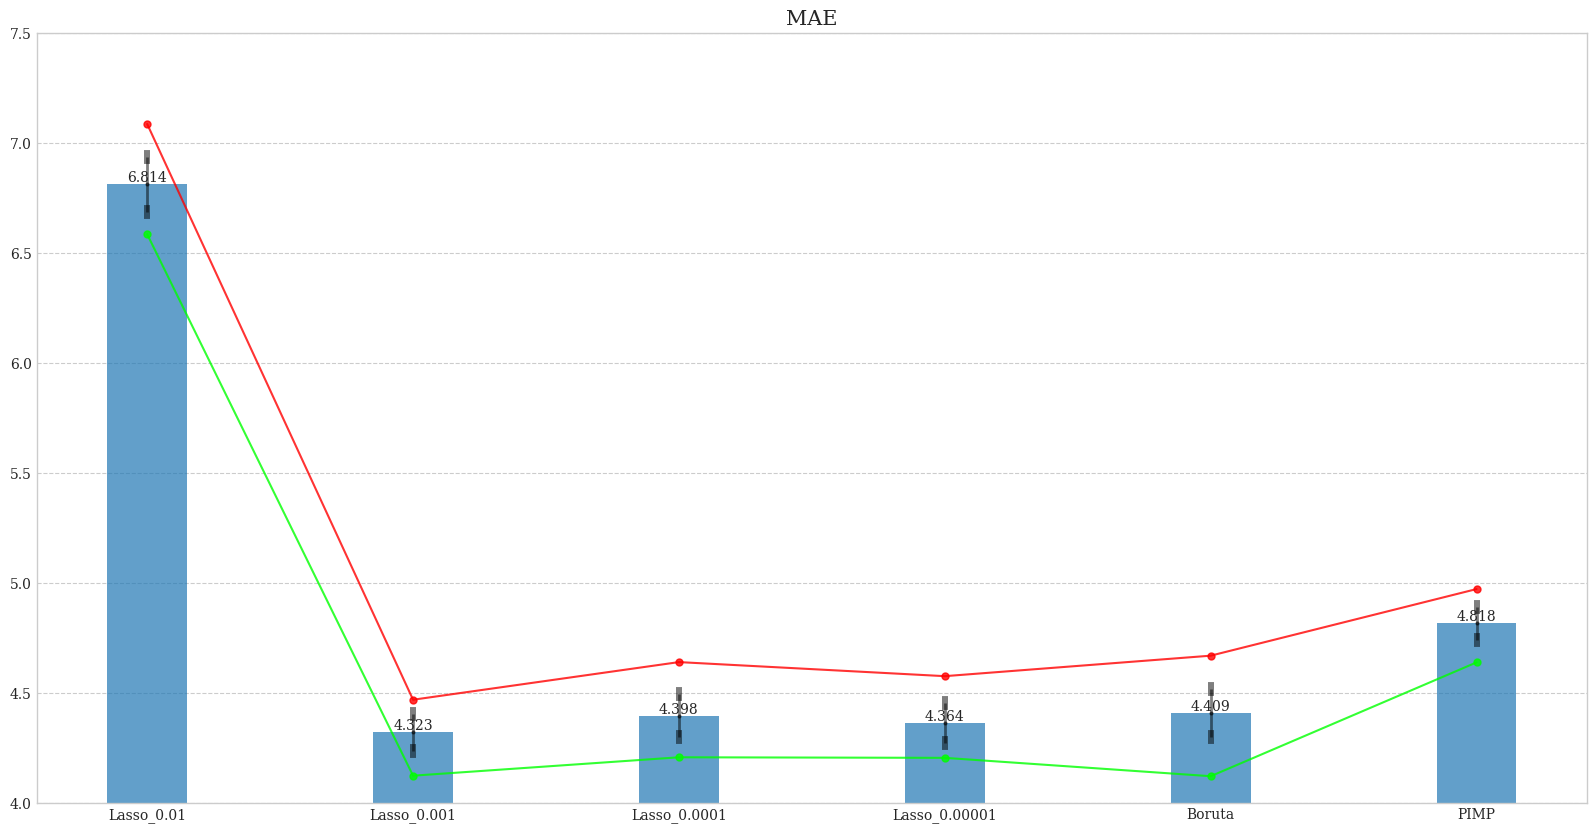

In [67]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_mae_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_mae_mean, resultados_mae_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_mae_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_mae_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("MAE")
ax.title.set_size(15)
for index,data in enumerate(resultados_mae_mean):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([4, 7.5])


## RMSE

In [57]:
resultados_rmse_mean = [mean_lasso_001_test['rmse'], mean_lasso_0001_test['rmse'], mean_lasso_00001_test['rmse'], mean_lasso_000001_test['rmse'], mean_boruta_test['rmse'], mean_pimp_test['rmse']]
resultados_rmse_std = [std_lasso_001_test['rmse'], std_lasso_0001_test['rmse'], std_lasso_00001_test['rmse'], std_lasso_000001_test['rmse'], std_boruta_test['rmse'], std_pimp_test['rmse']]
resultados_rmse_max = [max_lasso_001_test['rmse'], max_lasso_0001_test['rmse'], max_lasso_00001_test['rmse'], max_lasso_000001_test['rmse'], max_boruta_test['rmse'], max_pimp_test['rmse']]
resultados_rmse_min = [min_lasso_001_test['rmse'], min_lasso_0001_test['rmse'], min_lasso_00001_test['rmse'], min_lasso_000001_test['rmse'], min_boruta_test['rmse'], min_pimp_test['rmse']]

(6.5, 12.0)

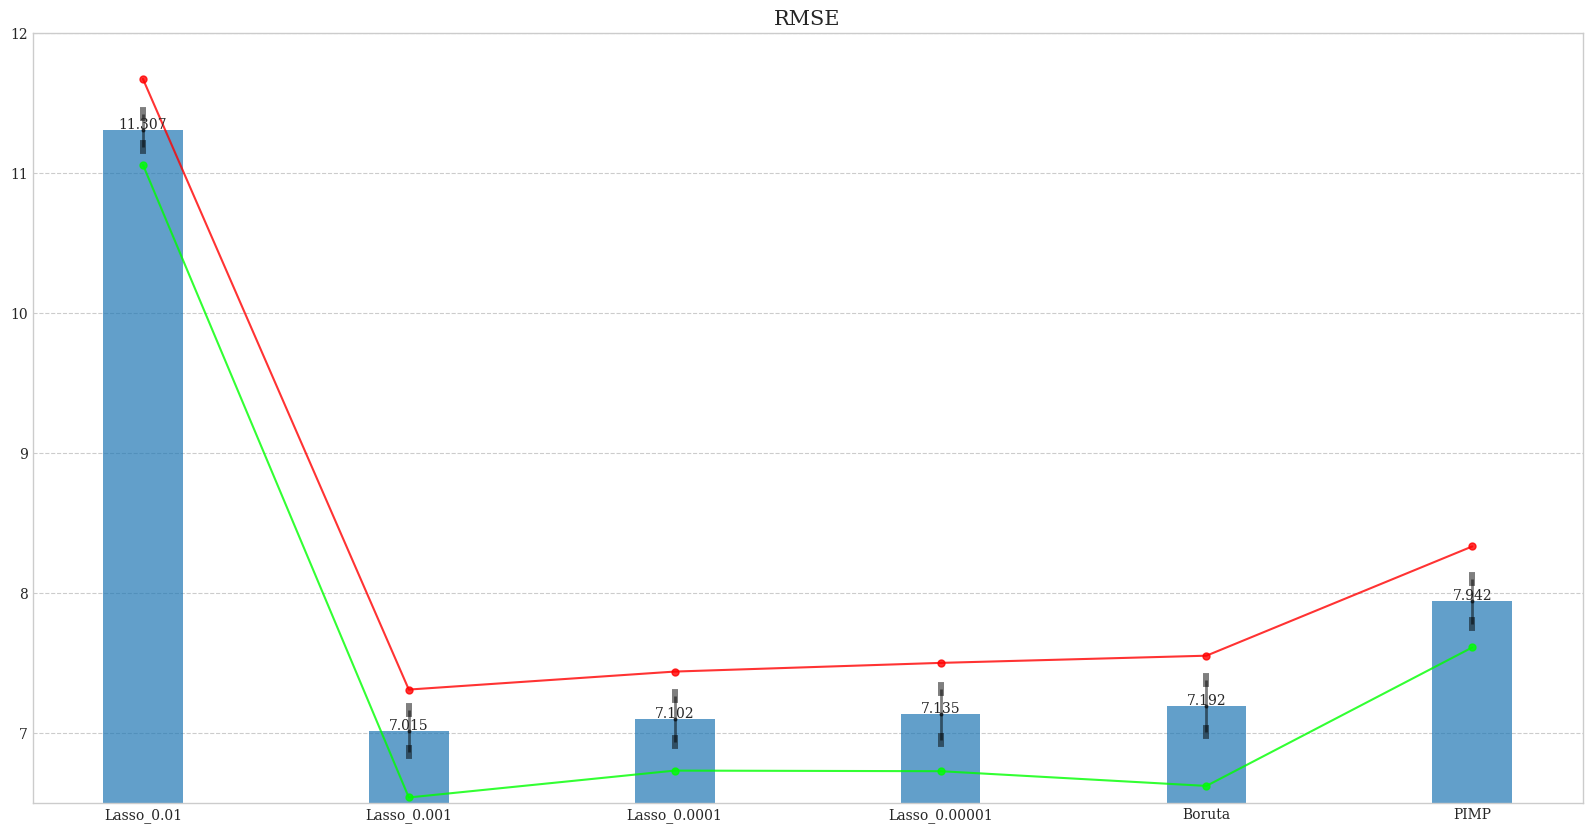

In [65]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_rmse_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_rmse_mean, resultados_rmse_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_rmse_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_rmse_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("RMSE")
ax.title.set_size(15)
for index,data in enumerate(resultados_rmse_mean):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([6.5, 12])

## R2

In [59]:
resultados_r2_mean = [mean_lasso_001_test['r2'], mean_lasso_0001_test['r2'], mean_lasso_00001_test['r2'], mean_lasso_000001_test['r2'], mean_boruta_test['r2'], mean_pimp_test['r2']]
resultados_r2_std = [std_lasso_001_test['r2'], std_lasso_0001_test['r2'], std_lasso_00001_test['r2'], std_lasso_000001_test['r2'], std_boruta_test['r2'], std_pimp_test['r2']]
resultados_r2_max = [max_lasso_001_test['r2'], max_lasso_0001_test['r2'], max_lasso_00001_test['r2'], max_lasso_000001_test['r2'], max_boruta_test['r2'], max_pimp_test['r2']]
resultados_r2_min = [min_lasso_001_test['r2'], min_lasso_0001_test['r2'], min_lasso_00001_test['r2'], min_lasso_000001_test['r2'], min_boruta_test['r2'], min_pimp_test['r2']]

In [60]:
resultados_r2_max, resultados_r2_min

([0.7283477140162204,
  0.904984462346938,
  0.8993269984101486,
  0.8994535388566154,
  0.902571031292214,
  0.8713006027143375],
 [0.6973944371214218,
  0.8812744927298166,
  0.8770653985849344,
  0.875005231004745,
  0.8732900295957418,
  0.8457520133660061])

(0.65, 0.95)

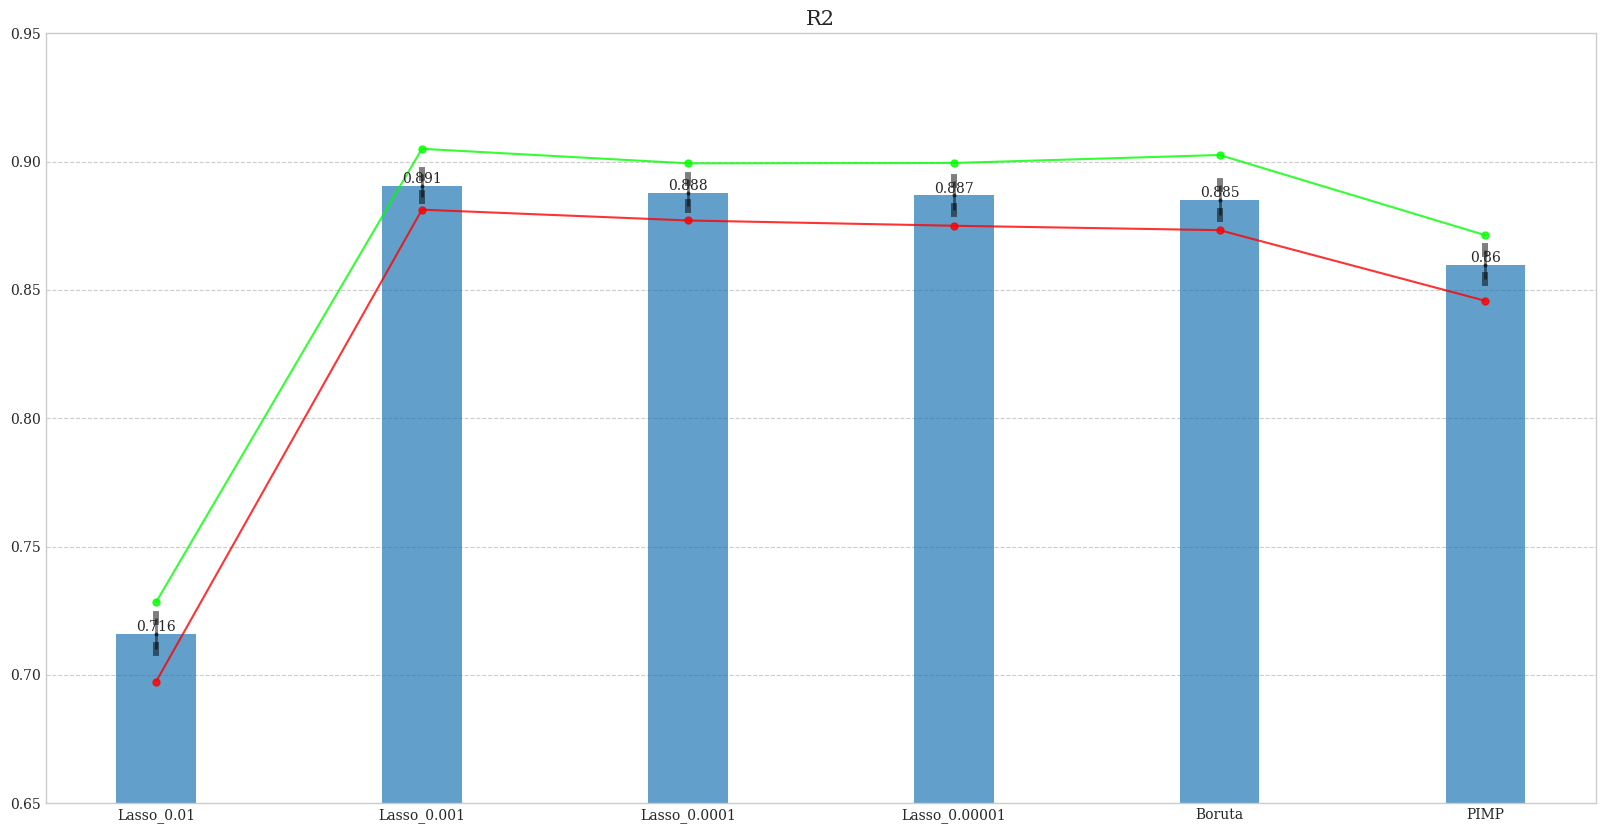

In [64]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_r2_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_r2_mean, resultados_r2_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_r2_max, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_r2_min, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("R2")
ax.title.set_size(15)
for index,data in enumerate(resultados_r2_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0.65, 0.95])

## Number of variables

In [62]:
n_var = [len(features_lasso_001), len(features_lasso_0001), len(features_lasso_00001), len(features_lasso_000001), len(selected_features_boruta), len(selected_features_pimp)]

(0.0, 355.0)

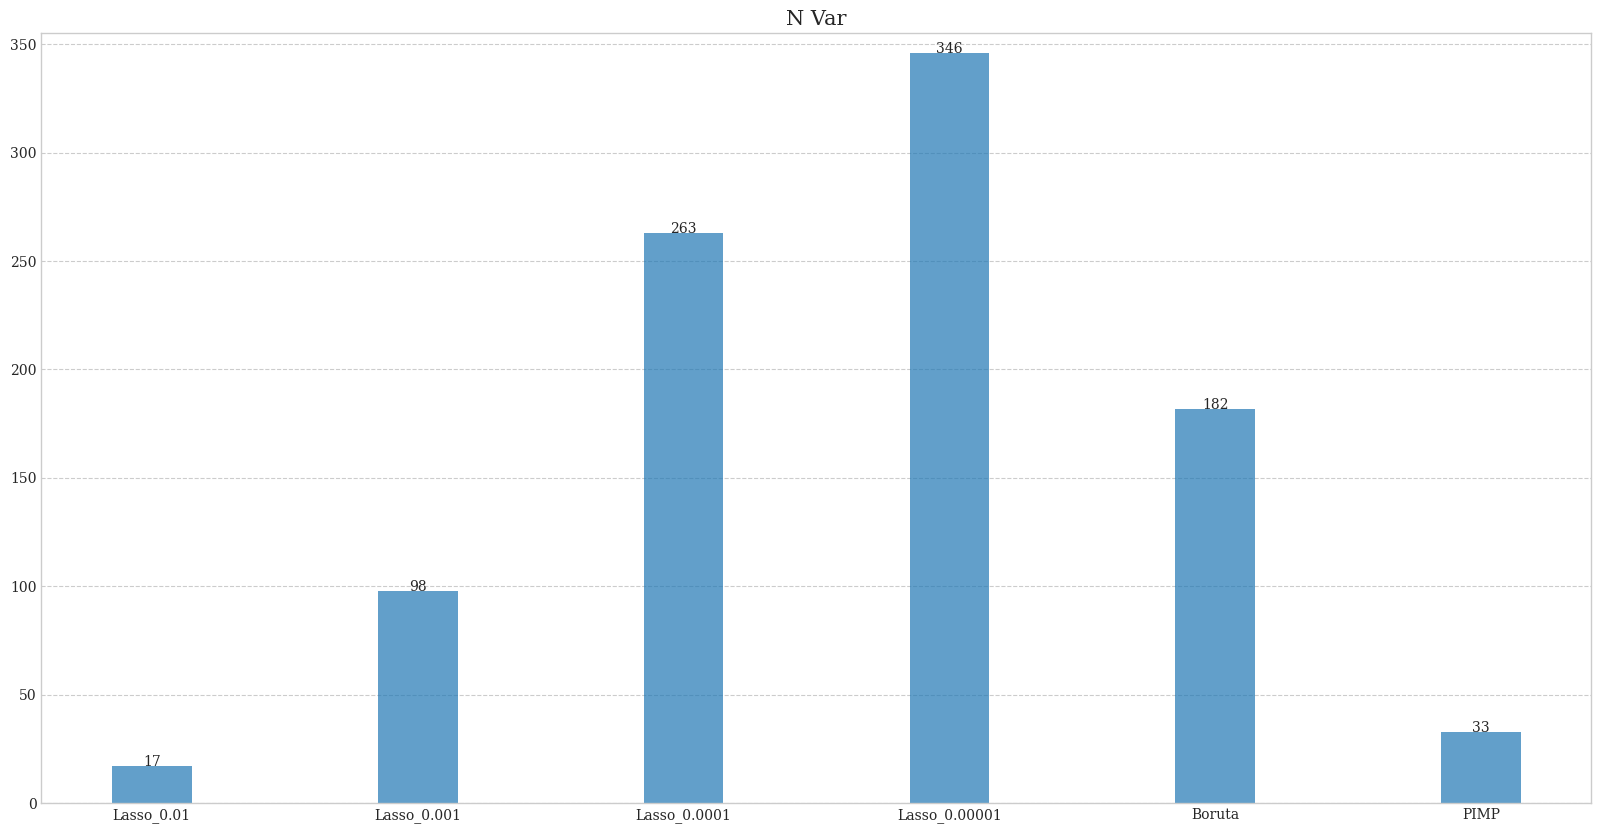

In [63]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
bars = ax.bar(nombres, n_var, alpha = 0.7, width=0.3)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("N Var")
ax.title.set_size(15)
for index,data in enumerate(n_var):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0, 355])